# Construction Safety Classifier
## DIGIMAP - S13
### Submitted by: Darius Vincent Ardales

# Importing Dependencies

In [161]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split

# For reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Checking the Data

### Initializing directories

In [162]:
base_dir = './data'

safe_dir = os.path.join(base_dir, 'safe')
unsafe_dir = os.path.join(base_dir, 'unsafe')

augmented_safe_dir = os.path.join(base_dir, 'augmented_safe')
augmented_unsafe_dir = os.path.join(base_dir, 'augmented_unsafe')

# Create augmented directories if they do not exist
os.makedirs(augmented_safe_dir, exist_ok=True)
os.makedirs(augmented_unsafe_dir, exist_ok=True)

### Check for image size consistency in the dataset

In [163]:
def check_consistent_image_size(folder_path, name):
    """
    Checks if all images in the specified folder have consistent dimensions.

    Args:
        folder_path (str): Path to the folder containing images.
        name (str): Placeholder name.

    Returns:
        tuple: Dimensions (width, height) if all images have consistent size, or None if they do not.
    """
    n_files = sum([1 for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    print(f"Number of files in {name} : {n_files}")

    consistent_size = None
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
            file_path = os.path.join(folder_path, filename)
            try:
                with Image.open(file_path) as image:
                    width, height = image.size
                    if consistent_size is None:
                        consistent_size = (width, height)
                    elif consistent_size != (width, height):
                        print("Not all images have consistent dimensions.")
                        return None
            except Exception as e:
                print(f"Error opening image {filename}: {e}")

    if consistent_size:
        print(f"All images have consistent dimensions: {consistent_size[0]}x{consistent_size[1]}")
        return consistent_size
    else:
        print("No valid images found in the specified folder.")
        return None

In [164]:
check_consistent_image_size(safe_dir, "Safe Images")

Number of files in Safe Images : 1010
All images have consistent dimensions: 640x640


(640, 640)

In [165]:
check_consistent_image_size(unsafe_dir, "Unsafe Images")

Number of files in Unsafe Images : 1010
All images have consistent dimensions: 640x640


(640, 640)

# Data Augmentation

### Sample for testing the functions

In [166]:
sample_image_path = os.path.join(safe_dir, '1.jpg')
sample_image = cv.imread(sample_image_path)

In [167]:
def display_images(image1, image2, title1="Before", title2="After"):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv.cvtColor(image1, cv.COLOR_BGR2RGB))
    plt.title(title1)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(cv.cvtColor(image2, cv.COLOR_BGR2RGB))
    plt.title(title2)
    plt.axis('off')
    plt.show()

### Randomly putting a black patch over a portion of an image

In [168]:
# Function to randomly place a black patch over a portion of the image
def random_black_patch(image, patch_size=(64, 64)):
    image_copy = image.copy()
    rows, cols, _ = image_copy.shape
    
    x = np.random.randint(0, cols - patch_size[1])
    y = np.random.randint(0, rows - patch_size[0])

    # Setting the value to 0 makes it black
    image_copy[y:y + patch_size[0], x:x + patch_size[1]] = 0  
    return image_copy

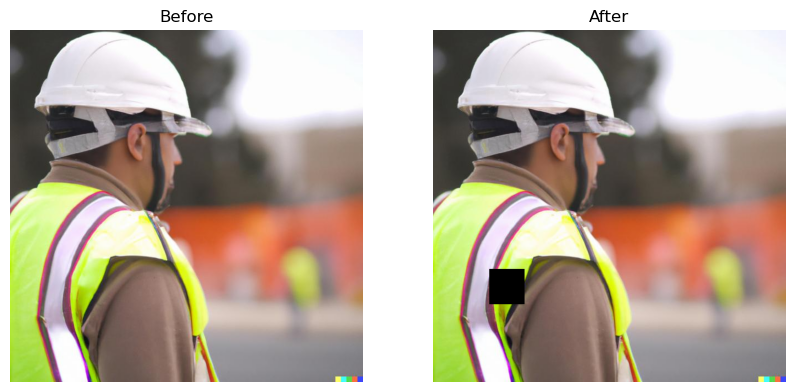

In [169]:
display_images(sample_image, random_black_patch(sample_image))

### Shifting an image sideward or upwards

In [170]:
# Function to shift an image either sideward or upward
def shift_image(image, x=64, y=64):
    image_copy = image.copy()
    rows, cols, ch = image_copy.shape
    
    M = np.float32([[1, 0, x], [0, 1, y]])
    shifted_image = cv.warpAffine(image_copy, M, (cols, rows))
    return shifted_image

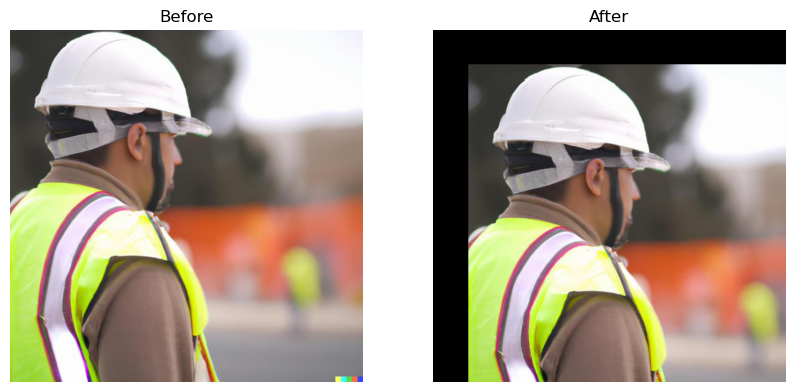

In [171]:
display_images(sample_image, shift_image(sample_image))

### Rotating an image

In [172]:
def rotate_image(image, theta=30, scale=1.0, center=None):
    image_copy = image.copy()
    rows, cols, ch = image_copy.shape
    
    # If no center is provided, use the geometric center of the image
    if center is None:
        center = ((cols - 1) / 2.0, (rows - 1) / 2.0)
    
    M = cv.getRotationMatrix2D(center, theta, scale)
    rotated_image = cv.warpAffine(image_copy, M, (cols, rows))
    
    return rotated_image

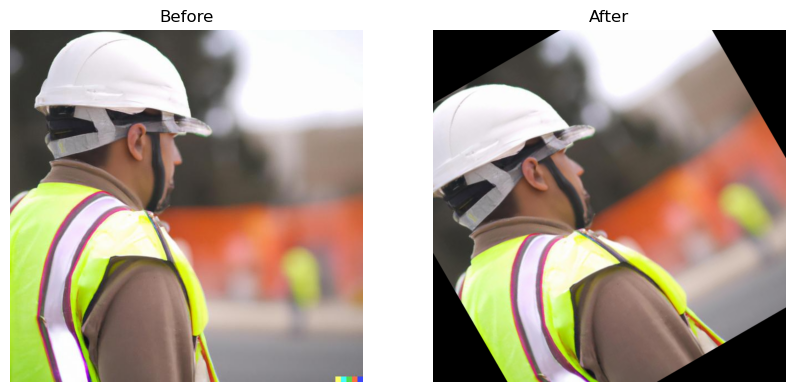

In [173]:
display_images(sample_image, rotate_image(sample_image))

### Flipping an image either vertically or horizontally

In [174]:
# Function to flip an image vertically or horizontally
def flip_image(image, flip_code=1):
    image_copy = image.copy()
    
    # flip_code: 1 = horizontal, 0 = vertical, -1 = both
    flipped_image = cv.flip(image_copy, flip_code)
    return flipped_image

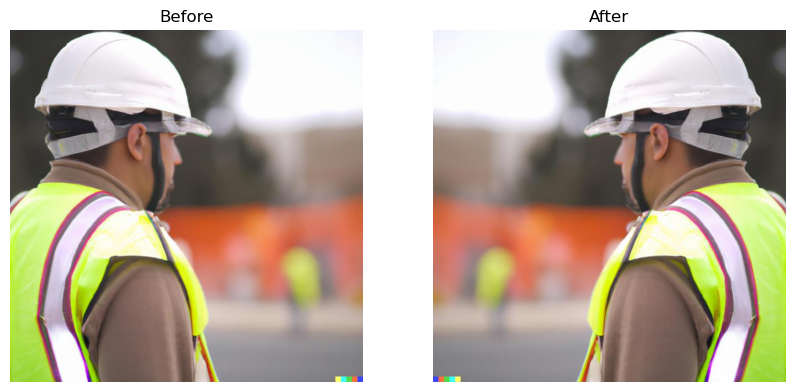

In [175]:
display_images(sample_image, flip_image(sample_image))

### Increase or decrease the saturation

In [176]:
# Function to adjust the saturation of an RGB image
def adjust_saturation(image, scale=1.5):
    hsv_image = cv.cvtColor(image, cv.COLOR_RGB2HSV)
    h, s, v = cv.split(hsv_image)
    
    s = np.clip(s * scale, 0, 255).astype(np.uint8)
    
    # Merge the channels back and convert to RGB
    adjusted_hsv = cv.merge([h, s, v])
    adjusted_rgb = cv.cvtColor(adjusted_hsv, cv.COLOR_HSV2RGB)
    
    return adjusted_rgb

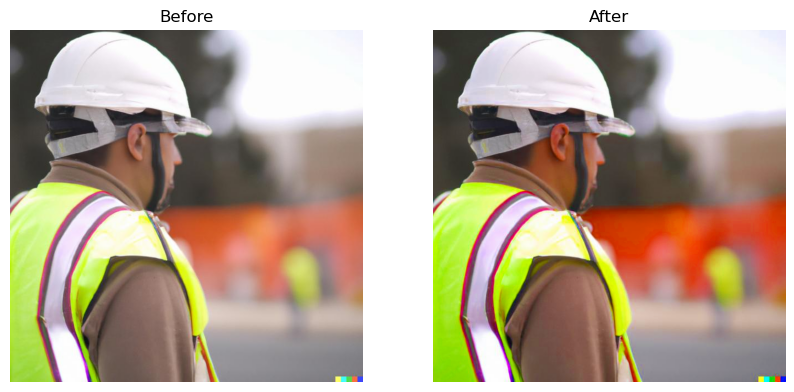

In [177]:
display_images(sample_image, adjust_saturation(sample_image))

### Apply the Augmentations

In [178]:
# Apply augmentation functions to each image
def apply_augmentations(image_dir, augmented_dir):
    augmentation_funcs = [random_black_patch, shift_image, rotate_image, flip_image, adjust_saturation]
    
    for image_name in os.listdir(image_dir):
        if image_name.endswith(('.jpg', '.png', '.jpeg')):
            image_path = os.path.join(image_dir, image_name)
            image = cv.imread(image_path)
            
            base_name = os.path.splitext(image_name)[0]
            
            # Apply each augmentation function with randomized parameters
            for i, func in enumerate(augmentation_funcs):
                if func == random_black_patch:
                    augmented_image = func(image, patch_size=(np.random.randint(32, 128), np.random.randint(32, 128)))
                elif func == shift_image:
                    augmented_image = func(image, x=np.random.randint(-64, 64), y=np.random.randint(-64, 64))
                elif func == rotate_image:
                    augmented_image = func(image, theta=np.random.randint(-45, 45), scale=np.random.uniform(0.8, 1.2))
                elif func == flip_image:
                    augmented_image = func(image, flip_code=np.random.choice([0, 1, -1]))
                elif func == adjust_saturation:
                    augmented_image = func(image, scale=np.random.uniform(0.5, 1.5))
                
                # Save augmented image
                augmented_image_name = f"{base_name}_{chr(97 + i)}.jpg"
                augmented_image_path = os.path.join(augmented_dir, augmented_image_name)
                cv.imwrite(augmented_image_path, augmented_image)
            
            # Save original image to augmented directory
            original_image_path = os.path.join(augmented_dir, f"{base_name}.jpg")
            cv.imwrite(original_image_path, image)

In [179]:
# # Apply augmentations to safe and unsafe images
# apply_augmentations(safe_dir, augmented_safe_dir)
# apply_augmentations(unsafe_dir, augmented_unsafe_dir)

Each folder should have 6060 images

In [180]:
check_consistent_image_size(augmented_safe_dir, "Augmented Safe Images")

Number of files in Augmented Safe Images : 6060
All images have consistent dimensions: 640x640


(640, 640)

In [181]:
check_consistent_image_size(augmented_unsafe_dir, "Augmented Unsafe Images")

Number of files in Augmented Unsafe Images : 6060
All images have consistent dimensions: 640x640


(640, 640)

# Preparing the Data

### Initializing Dataset Class

In [182]:
class SafetyDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
        self.transform = transform
        self.labels = [0 if 'unsafe' in image_dir else 1] * len(self.image_files)

    def __len__(self):
        return len(self.image_files) 

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx])
        image = cv.imread(img_name)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label 

### Initializing Transformation to Tensor

In [183]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

### Loading the Datasets

In [184]:
safe_dataset = SafetyDataset(augmented_safe_dir, transform=transform)
unsafe_dataset = SafetyDataset(augmented_unsafe_dir, transform=transform)

print(f"Safe Dataset Length: {safe_dataset.__len__()}")
print(f"Unsafe Dataset Length: {unsafe_dataset.__len__()}")

Safe Dataset Length: 6060
Unsafe Dataset Length: 6060


In [ ]:
image, label = safe_dataset[1]
print(f"Image Shape: {image.shape}, Label: {label}")
image, label = unsafe_dataset[1]
print(f"Image Shape: {image.shape}, Label: {label}")

Image Shape: torch.Size([3, 640, 640]), Label: 1
Image Shape: torch.Size([3, 640, 640]), Label: 0


### Combining the Datasets

In [205]:
# Combine datasets using ConcatDataset to support indexing
full_dataset = torch.utils.data.ConcatDataset([safe_dataset, unsafe_dataset])

print(f"Full Dataset Length: {full_dataset.__len__()}, Type: {type(full_dataset)}")

Full Dataset Length: 12120, Type: <class 'torch.utils.data.dataset.ConcatDataset'>


### Train test split

In [208]:
# Split dataset into train and test sets (80% train, 20% test)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

print(f"Train Dataset Length: {train_dataset.__len__()}, Type: {type(train_dataset)}")
print(f"Test Dataset Length: {test_dataset.__len__()}, Type: {type(test_dataset)}")

Train Dataset Length: 9696, Type: <class 'torch.utils.data.dataset.Subset'>
Test Dataset Length: 2424, Type: <class 'torch.utils.data.dataset.Subset'>


# Other Helper Functions

Since the data from Kaggle was already split into `train`, `val`, `test`. I wanted to consolidate all of them. To avoid duplicate names, I renamed some of the image files using the function below.

In [ ]:
def rename_images(folder_path, start_number):
    """
    Renames all image files in the given folder based on a starting number.
    
    Parameters:
    folder_path (str): The path to the folder containing the image files to rename.
    start_number (int): The starting number for renaming the image files.
    
    The files will be renamed sequentially from the starting number, with the format "<start_number>.jpg", "<start_number + 1>.jpg", etc.
    """
    # List all files in the folder
    files = os.listdir(folder_path)
    
    # Sort files to maintain consistent renaming order
    files.sort()
    
    # Iterate over all files and rename them based on the given number
    for idx, filename in enumerate(files):
        # Construct new file name with the given number and its index
        new_name = f"{start_number + idx}.jpg"
        
        # Create full paths for the old and new file names
        old_path = os.path.join(folder_path, filename)
        new_path = os.path.join(folder_path, new_name)
        
        # Rename the file
        os.rename(old_path, new_path)